In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset

import os
import itertools

import pyrocko
from pyrocko import obspy_compat
obspy_compat.plant()

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [5]:
AVG_EARTH_RADIUS_KM = 6371.0088

NETWORKS = "IS"
STATIONS = ','.join(['MLDT', 'CVYN', 'MNHM', 'SHGL', 'ALMT', 'GLHS', 'ENGV', 'TVR', 'MGDL', 'SPR', 'KNHM', 
                    'RMOT', 'HDNS', 'AMID', 'ZEFT', 'RSPN', 'KSHO', 'KDZV', 'HULT', 'ZRT'])
CHANNELS = str([''.join(ch) for ch in itertools.product("BHSE", "LHN", "?")])[1:-1].replace("'", '')

LAT = 32.80
LON = 35.60
MAX_RAD = 0.4
MIN_MAG = 2.0
DOWNLOAD_INV_CAT = False
DOWNLOAD_EVENTS = False
PICK = False
CATALOG_PATH = "catalog.xml"
INV_PATH = "inventory.xml"
WAVEFORMS_PATH = 'waveforms'
PICK_DIR_PATH = 'picking'

In [6]:
completed_idx = 0

In [7]:
# Module that download waveforms
def download_event_waveforms(client, t0, t1, networks="*", stations="*", locations="*", channels="*"):
    st = client.get_waveforms(network=networks, station=stations, location=locations, channel=channels, starttime=t0, endtime=t1)
    st = st.slice(starttime=t0, endtime=t1)
    st.write(filename=f"{t0}-{t1}.mseed", format="MSEED")
    return st

def haversine(points1, points2):
    """ Calculate the great-circle distance between two points on the Earth surface.
    :inp: two 2-tuples, containing the latitude and longitude of each point
    in decimal degrees.
    Example: haversine((45.7597, 4.8422), (48.8567, 2.3508))
    :output: Returns the distance between the two points in km.
    """
    # get earth radius in required units
    avg_earth_radius = AVG_EARTH_RADIUS_KM

    # unpack latitude/longitude
    lats1, lons1 = points1
    lats2, lons2 = points2

    # convert all latitudes/longitudes from decimal degrees to radians
    lats1, lons1, lats2, lons2 = map(np.radians, (lats1, lons1, lats2, lons2))

    # calculate haversine

    distance = np.arcsin(np.sqrt(
        np.sin((lats2 - lats1) * 0.5) ** 2
        + (np.cos(lats1) * np.cos(lats2) * np.sin((lons2 - lons1) * 0.5) ** 2)))
    return 2 * avg_earth_radius * distance

def bearing(points1, points2):
    
    # unpack latitude/longitude
    lats1, lons1 = points1
    lats2, lons2 = points2
    # convert all latitudes/longitudes from decimal degrees to radians
    lats1, lons1, lats2, lons2 = map(np.radians, (lats1, lons1, lats2, lons2))
    
    # calculate bearing
    dlons = lons2 - lons1
    y = np.sin(dlons) * np.cos(lats2)
    x = np.cos(lats1) * np.sin(lats2) - np.sin(lats1) * np.cos(lats2) * np.cos(dlons)
    return np.arctan2(y, x)

def absolute2relative(points1, points2):
    
    dist = haversine(points1, points2)
    azim = bearing(points1, points2)    
    return dist * np.sin(azim), dist * np.cos(azim)

def conversite(latitudes, longitudes, grid_size=100):
    min_lat = latitudes.min()
    max_lat = latitudes.max()
    
    min_lon = longitudes.min()
    max_lon = longitudes.max()
    
    grid_max = absolute2relative((min_lon, min_lat), (max_lat, max_lon))
    rstations = absolute2relative(np.tile((min_lat, min_lon), (len(latitudes), 1)).T,
                                  (latitudes, longitudes))
    
    return rstations, max(grid_max) / grid_size


In [8]:
isr_fdsn = "http://82.102.143.46:8181"
client = Client(isr_fdsn)#, user='niv.keren@gmail.com', password='fdsnisfun1', timeout=240)

In [9]:
my_events = pd.read_csv("events.csv").sort_values(["event time"])
all_events = pd.read_csv("all_events.csv").set_index('event_time')
waveforms_raw = []
waveforms_detrented = []
waveforms_filtered = []

In [10]:
for idx, event in my_events.iterrows():
    cat_event = all_events.loc[event['event time']]
    my_events.loc[idx, "cat_lat"] = cat_event.lat
    my_events.loc[idx, "cat_lon"] = cat_event.lon
    my_events.loc[idx, "cat_mag"] = cat_event.magnitude
my_events

,event time,cat_lat,cat_lon,cat_mag
0,2018-07-04T01:50:06.667000Z,32.848,35.583,4.797476941 M
2,2018-07-04T01:54:26.532000Z,32.859,35.585,2.552366975 M
3,2018-07-04T03:57:39.993000Z,32.840,35.597,3.288243713 M
1,2018-07-04T19:45:39.428000Z,32.843,35.572,4.761445325 M
4,2018-07-04T19:51:24.449000Z,32.852,35.578,3.821342778 M
5,2018-07-05T04:00:03.956000Z,32.848,35.579,2.975286543 M
6,2018-07-05T16:51:36.987000Z,32.836,35.574,2.957468776 M
7,2018-07-06T05:38:54.227000Z,32.861,35.569,2.760879312 M
8,2018-07-07T02:07:44.383000Z,32.837,35.599,3.993414954 M
9,2018-07-08T12:52:17.385000Z,32.846,35.578,3.099346613 M


### **Download FDSN Inventory & Catalog**

In [11]:
def download_inv(client, events_times, networks, stations, channels):
    day_sec = 24 * 3600
    level="response"
    inv_start = UTCDateTime(events_times.min()) - day_sec
    inv_end = UTCDateTime(events_times.max()) + day_sec

    inv = client.get_stations(starttime=inv_start, endtime=inv_end, network=networks, station=stations, channel=channels, level=level)
    params = {"start": inv_start,
              "end": inv_end,
              "networks": networks,
              "stations": stations,
              "channels": channels,
              "level": level}
    return inv, params
    
def download_catalog(client, events_times, lat, lon, max_rad, min_mag, inc_arrivals=True, inc_picks=True):
    cat_start = UTCDateTime(events_times.min()) - 1
    cat_end = UTCDateTime(events_times.max()) + 1
    cat_events = client.get_events(starttime=cat_start, endtime=cat_end,
                                   latitude=lat, longitude=lon, maxradius=max_rad, minmagnitude=min_mag, includearrivals=inc_arrivals, includepicks=inc_picks)
    
    matched = []
    not_matched = []
    catalog = obspy.Catalog()
    for i, event_time in enumerate(events_times):
        for cat_event in cat_events.events[::-1]:
            origin = cat_event.preferred_origin() or cat_event.origins[-1]
            if origin is None:
                continue
            if event_time == str(origin.time):
                catalog.append(cat_event)
                matched.append(i)
                break
        else:
            not_matched.append(i)
    params = {"start": cat_start,
              "end": cat_end,
              "matched": matched,
              "not_matched": not_matched}
    return catalog, params

def download_inv_cat(client, events_times, networks, stations, lat, lon, max_rad, min_mag, inc_arrivals=True, inc_picks=True, write=True):
    inv, inv_params = download_inv(client, events_times, networks, stations)
    catalog, cat_params = download_catalog(client, events_times, lat, lon, max_rad, min_mag, inc_arrivals, inc_picks)
    print(f"strat time: inventory-{inv_params['start']}, catalog-{cat_params['start']}")
    print(f"end time:   inventory-{inv_params['end']}, catalog-{cat_params['end']}")
    print(f"networks: {inv_params['networks']}")
    print(f"stations: {inv_params['stations']}")
    print(f"channels: {inv_params['channels']}")
    print(f"matched events: {cat_params['matched']}")
    print(f"not matched events: {cat_params['not_matched']}")
    
    if write:
        catalog.write("catalog.xml", format="QUAKEML")
        inv.write("inventory.xml", format="STATIONXML")
    return inv, catalog

### **Load FDSN Inventory & Catalog**

In [12]:
if DOWNLOAD_INV_CAT:
    inv, catalog = download_inv_cat(client, my_events["event time"], NETWORKS, STATIONS, CHANNELS, LAT, LON, MAX_RAD, MIN_MAG)
else:
    inv = obspy.read_inventory(INV_PATH, format="STATIONXML")
    catalog = obspy.read_events(CATALOG_PATH, format="QUAKEML")

In [13]:
def download_waveforms(events, networks, stations, channels, before=5, after=30, min_freq=1, max_freq=10):
    waveforms_raw = []
    waveforms_detrented = []
    waveforms_filtered = []
    for idx, event in events.iterrows():
        t = UTCDateTime(event["event time"])
        start_time = t - before
        end_time = t + after
        print(f"downloading mseed wavform file from : {start_time} to : {end_time}")
        st = download_event_waveforms(client=client, t0=start_time, t1=end_time, networks=networks, stations=stations, channels=channels)
        st_detrened, st_filtered = procces_waveform(st, min_freq, max_freq)
        waveforms_raw.append(st)
        waveforms_detrented.append(st_detrened)
        waveforms_filtered.append(st_filtered)
    return waveforms_raw, waveforms_detrented, waveforms_filtered

def load_waveforms(dir_path='.', min_freq=1, max_freq=10):    
    waveforms_raw = []
    waveforms_detrented = []
    waveforms_filtered = []
    mseed_paths = [os.path.join(dir_path,path) for path in os.listdir(dir_path) 
                   if os.path.isfile(os.path.join(dir_path,path)) and path.lower().endswith('.mseed')]
    for path in mseed_paths:
        print(f"loading mseed file: {path}")
        st = obspy.read(path, format="MSEED")
        st_detrened, st_filtered = procces_waveform(st, min_freq, max_freq)
        waveforms_raw.append(st)
        waveforms_detrented.append(st_detrened)
        waveforms_filtered.append(st_filtered)
    return waveforms_raw, waveforms_detrented, waveforms_filtered

def procces_waveform(st, min_freq=1, max_freq=10):
    st_detrened = st.copy().detrend("linear")
    st_filtered = st_detrened.copy().filter("bandpass", freqmin=min_freq, freqmax=max_freq)
    return st_detrened, st_filtered

In [14]:
if DOWNLOAD_EVENTS:
    waveforms_raw, waveforms_detrented, waveforms_filtered = download_waveforms(my_events, NETWORKS, STATIONS, CHANNELS)
else:
    waveforms_raw, waveforms_detrented, waveforms_filtered = load_waveforms(WAVEFORMS_PATH)

loading mseed file: waveforms/2018-07-07T02:07:39.383000Z-2018-07-07T02:08:14.383000Z.mseed
loading mseed file: waveforms/2018-07-12T07:00:30.280000Z-2018-07-12T07:01:05.280000Z.mseed
loading mseed file: waveforms/2018-07-04T19:45:34.428000Z-2018-07-04T19:46:09.428000Z.mseed
loading mseed file: waveforms/2018-07-18T15:24:04.149000Z-2018-07-18T15:24:39.149000Z.mseed
loading mseed file: waveforms/2018-07-04T19:51:19.449000Z-2018-07-04T19:51:54.449000Z.mseed
loading mseed file: waveforms/2018-07-27T11:56:32.960000Z-2018-07-27T11:57:07.960000Z.mseed
loading mseed file: waveforms/2018-07-10T19:25:15.385000Z-2018-07-10T19:25:50.385000Z.mseed
loading mseed file: waveforms/2018-07-29T00:07:49.796000Z-2018-07-29T00:08:24.796000Z.mseed
loading mseed file: waveforms/2018-07-05T16:51:31.987000Z-2018-07-05T16:52:06.987000Z.mseed
loading mseed file: waveforms/2018-07-04T01:50:01.667000Z-2018-07-04T01:50:36.667000Z.mseed
loading mseed file: waveforms/2018-07-31T01:30:44.702000Z-2018-07-31T01:31:19.70

### p picking

In [15]:
def distance_from_event(event, points, elevations, local_depths):
    origin = event.preferred_origin() or event.origins[-1]
    hypo_dist = haversine((points), np.tile((origin.latitude, origin.longitude), (points.shape[1], 1)).T)
    depth = (elevations - local_depths + origin.depth) / 1000
    epi_dist = np.sqrt((hypo_dist**2 + depth**2))
    return epi_dist, hypo_dist

def catalog_pick(event, network, station):
    cat_tp = None
    cat_ts= None
    
    for pick in event.picks:
        if (pick.waveform_id.network_code, pick.waveform_id.station_code) == (network, station):
            t = pick.time
            if pick.phase_hint in ('P', 'p'):
                cat_tp = t
            elif pick.phase_hint in ('S', 's'):
                cat_ts = t
    return cat_tp, cat_ts

def sta_lta_pick(tr, sta, lta, thres1, thres2, max_len=1):
    tp_sta = None
    
    sr = tr.stats.sampling_rate
    cft = recursive_sta_lta(tr.data, int(sta * sr), int(lta * sr))
    p = trigger_onset(cft, thres1, thres2, max_len=max_len)
    if len(p) > 0:
        tp_sta = UTCDateTime((tr.stats.starttime + tr.times()[p[0][0]]).timestamp)  
    return tp_sta

def hand_pick(st, freqmin=1, freqmax=10):   
    tp = None
    ts = None
    
    st_filtered = st_detrened.copy().detrend("linear").filter("bandpass", freqmin=freqmin, freqmax=freqmax)
    
    for tr_pick in st_filtered:
        tr_pick.stats.location = f"{freqmin}{freqmax}"
    st_pick = st_filtered + st.cpoy()
        
    picks = st_pick.snuffle(inventory=inv)
    for mark in picks[1]:
        mark.get_phasename()
        if mark.get_phasename()=="P":
            tp = UTCDateTime(mark.get_tmin())
        if mark.get_phasename()=="S":
            ts = UTCDateTime(mark.get_tmin())
    return tp, ts

def event_df(st, inv, event):
    cols = ["lat", "lon", "elevation", "local_depth", "sampling_rate", "distance_catalog", "tp_catalog", "ts_catalog", "tp_sta_lta", "tp", "ts"]
    index_cols = ["station", "channel"]
    df = pd.DataFrame(columns=index_cols + cols).set_index(index_cols)
    stz = st.select(component="Z")
    for tr in stz:
        network = tr.stats.network
        station = tr.stats.station
        channel = tr.stats.channel
        sr = tr.stats.sampling_rate
        coord = inv.get_coordinates(f"{network}.{station}.{tr.stats.location}.{channel}",
                                    tr.stats.starttime)
        lat, lon, elevation, local_depth = coord.values()
        st_station = st.select(station=station, channel=channel[0: 2] + '?').sort(reverse=True)
        
        tp_sta = np.nan
        tp = np.nan
        ts = np.nan
        cat_tp = np.nan
        cat_ts = np.nan        
        
        
        epi_dist, hypo_dist = distance_from_event(event, (lat, lon), elevation, local_depth)
        
        #catalog picks
        cat_tp, cat_ts = catalog_pick(event, network, station)
                
        # p pick with sta/lta
        tp_sta = sta_lta_pick(tr, 1, 5, 3, 1)
        
        print(f"distance form hypocenter: {hypo_dist} km")
        print(f"time between p and s waves: {hypo_dist / 8} s")
#         print(f"distance form epicenter: {epi_dist} km")
#         print(f"time between p and s waves: {epi_dist / 8} s")
        print("----")
        tp, ts = hand_pick(st_station)
        # cols = ["lat", "lon", "elevation", "local_depth", "sampling_rate", "distance_catalog", "tp_catalog", "ts_catalog", "tp_sta_lta", "tp", "ts"]
        df.loc[(station, channel[0: 2]), cols] = lat, lon, elevation, local_depth , sr, hypo_dist, \
                                                 cat_tp, cat_ts, tp_sta, tp, ts
    return df

### **Load picking**

In [16]:
index_cols = ["station", "channel"]
if PICK:
    for i in range(completed_idx + 1, len(my_events)):
        df_event = event_df(waveforms_raw[i], waveforms_filtered[i], inv, catalog[i])
        df_event.reset_index().to_csv(f'{my_events.loc[i, "event time"]}.csv')
        completed_idx = i
        events_dfs.append(df_event)
else:
    events_dfs = [pd.read_csv(os.path.join(PICK_DIR_PATH,path)).set_index(index_cols) for path in os.listdir(PICK_DIR_PATH) 
                  if os.path.isfile(os.path.join(PICK_DIR_PATH,path)) and path.lower().endswith('.csv')]


## **Location**

---


Text(0, 0.5, 'y')

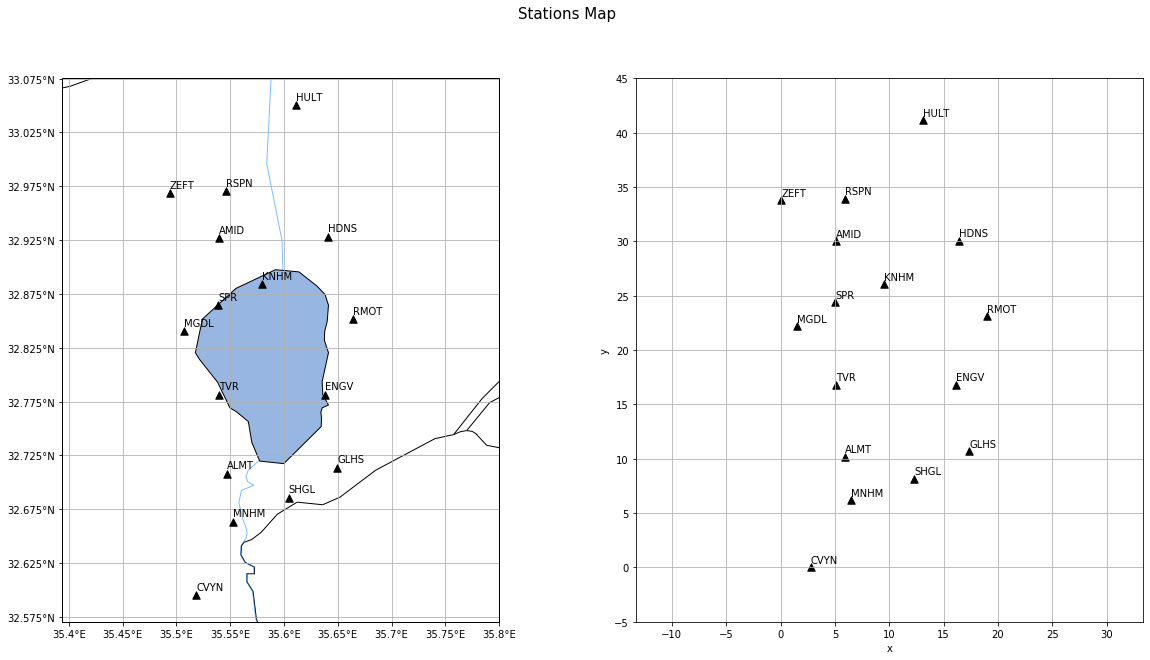

In [23]:
i = 10
event_data = events_dfs[i].dropna(axis="index", subset=["tp", "ts"])
event_data = event_data.drop(("GLHS", "HH"), axis='index')
num_stations = len(event_data)
(event_data["y"], event_data["x"]), delta = conversite(event_data["lon"], event_data["lat"], grid_size=100)

fig = plt.figure(figsize = (20, 10))
fig.suptitle('Stations Map', fontsize=15)

projection = ccrs.PlateCarree()
ax = fig.add_subplot(1, 2 ,1, projection = projection)
ax1 = fig.add_subplot(1, 2 ,2)
ax.set_extent([event_data["lon"].min() - 0.1,
               event_data["lon"].max() + 0.1,
               event_data["lat"].min() - 0.025,
               event_data["lat"].max() + 0.025],
              crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), edgecolor='k', facecolor=(0,0.85,1))
ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='k', alpha = 0.0, facecolor='none')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='k')
ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='k')
ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor=(0,0.5,1), alpha = 0.5)
ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='k', alpha = 1)

ax.grid(True)
ax.set_xticks(np.arange(event_data["lon"].min().round(1) - 0.1, event_data["lon"].max().round(1) + 0.1, 0.05),
              crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(event_data["lat"].min().round(1) - 0.025, event_data["lat"].max().round(1) + 0.025, 0.05), 
              crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# ax.set_title('Stations Map', fontsize=15)

ax.scatter(event_data["lon"], event_data["lat"], marker='^', s=55, c='k', zorder=2)
for station in event_data.iterrows():
    ax.text(station[1]["lon"], station[1]["lat"] + 0.005, station[0][0])
    ax1.text(station[1]["x"], station[1]["y"] + 0.4, station[0][0])
    
ax1.set_xlim(-8, event_data["x"].max() + 8)
ax1.set_ylim(-8, event_data["y"].max() + 8)

ax1.scatter(event_data["x"], event_data["y"], marker='^', s=55, c='k')
ax1.axis('equal')
ax1.grid(True)
marg_x, marg_y = 2, 1
ax1.set_xticks(np.arange(-(5 * marg_x), (np.ceil(event_data["x"].max()) // 5 + marg_x + 1) * 5, 5))
ax1.set_yticks(np.arange(-(5 * marg_y), (np.ceil(event_data["y"].max()) // 5 + marg_y + 1) * 5, 5))
ax1.set_xlabel('x')
ax1.set_ylabel('y')

In [24]:
pairs = list(itertools.combinations(range(num_stations), 2))
tds = [UTCDateTime(event_data.iloc[p[0]]["tp"]) - UTCDateTime(event_data.iloc[p[1]]["tp"]) for p in pairs]

In [25]:
depth=5
vp=2

In [26]:
event_data

,,Unnamed: 0,lat,lon,elevation,local_depth,sampling_rate,cat_tp,cat_ts,cat_distance,tp_sta_lta,tp,ts,y,x
station,channel,,,,,,,,,,,,,,
ZEFT,EN,0,32.968786,35.493747,803.0,0.0,200.0,15.253512,NaN,NaN,2018-07-27T11:56:40.610000Z,2018-07-27T11:56:40.533725Z,2018-07-27T11:56:43.093113Z,33.802923,0.063950
MNHM,EN,1,32.663572,35.552345,-132.0,0.0,200.0,21.136130,2018-07-04T19:45:43.345001Z,NaN,2018-07-27T11:56:37.960000Z,2018-07-27T11:56:43.611908Z,2018-07-27T11:56:46.447987Z,6.166657,6.517940
RMOT,EN,2,32.851506,35.664467,12.0,0.0,200.0,7.898340,2018-07-04T19:45:41.602996Z,2018-07-04T19:45:43.578002Z,2018-07-27T11:56:39.870000Z,2018-07-27T11:56:39.876585Z,2018-07-27T11:56:42.525623Z,23.135970,19.013287
SPR,EN,3,32.864735,35.538822,-177.0,0.0,200.0,4.082517,2018-07-04T19:45:40.847000Z,2018-07-04T19:45:42.402999Z,2018-07-27T11:56:38.780000Z,2018-07-27T11:56:38.735236Z,2018-07-27T11:56:39.980344Z,24.369273,5.045386
MGDL,EN,4,32.840339,35.507188,-83.0,5.0,200.0,6.921840,2018-07-04T19:45:41.233001Z,2018-07-04T19:45:42.910003Z,2018-07-27T11:56:39.455000Z,2018-07-27T11:56:39.426963Z,2018-07-27T11:56:41.363797Z,22.170619,1.522090
SHGL,EN,5,32.685752,35.604253,-166.0,4.0,200.0,18.651273,2018-07-04T19:45:43.052001Z,NaN,2018-07-27T11:56:43.150000Z,2018-07-27T11:56:42.781836Z,2018-07-27T11:56:48.004371Z,8.167915,12.291466
GLHS,EN,7,32.713434,35.649608,356.0,2.0,200.0,16.752582,2018-07-04T19:45:42.972000Z,2018-07-04T19:45:46.494003Z,2018-07-27T11:56:41.965000Z,2018-07-27T11:56:41.813419Z,2018-07-27T11:56:45.894605Z,10.664544,17.337362
HDNS,EN,8,32.927987,35.641179,0.0,0.0,200.0,10.181966,2018-07-04T19:45:42.301002Z,2018-07-04T19:45:44.750000Z,2018-07-27T11:56:39.870000Z,2018-07-27T11:56:39.807412Z,2018-07-27T11:56:41.965608Z,30.053987,16.444419
HULT,EN,9,33.050382,35.610995,117.0,0.0,200.0,22.223088,NaN,NaN,NaN,2018-07-27T11:56:42.678077Z,2018-07-27T11:56:45.825433Z,41.129796,13.132307


In [86]:
wx = 100
wy = 100

#minX=0
#minY=0

# mean residual sum (storage for residuals) 
mrs = np.zeros((wx,wy))

xv, yv = np.meshgrid(np.arange(wx) * delta, np.arange(wy) * delta)
# np.tile(event_data["x"].values, (100, 1))
np.sqrt((xv - np.tile(event_data["x"].values, (100, 100, 1)).T)**2 +
        (yv - np.tile(event_data["y"].values, (100, 100, 1)).T)**2 +
        (0 - depth)**2) / vp

# [np.sqrt((event_data.iloc[s]["x"] - gx)**2 + (event_data.iloc[s]["y"] - gy)**2 + (0 - depth)**2) / vp for s in range(num_stations)]
# for i in range(wx):
#     for j in range(wy):
#         print(j, i)
#     break

# for y in range(wy):
#     for x in range(wx):
        
#         gx = x * delta
#         gy = y * delta

#         tt1 = [np.sqrt((event_data.iloc[s]["x"] - gx)**2 + (event_data.iloc[s]["y"] - gy)**2 + (0 - depth)**2) / vp for s in range(num_stations)]
        
#         rSum1 = np.abs([(tt[ci[0]] - tt[ci[1]]) - td for ci, td in zip(pairs, tds)]).sum()
        
#         tt = [0 for i in range(num_stations)]
#         for s in range(num_stations):      
#             tt[s]= np.sqrt((event_data.iloc[s]["x"] - gx)**2 + (event_data.iloc[s]["y"] - gy)**2 + (0-depth)**2) / vp
# #         print(tt)
# #         print(tt1)
# #         break
#         rSum = 0
#         for ci in range(len(pairs)): 

# #             #CONSTRAINTS (ci): thickness of constraints
# #             #if np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]) < 0.1: rSum+=1
#             #RESIDUA
#             rSum += np.abs((tt[pairs[ci][0]] - tt[pairs[ci][1]]) - tds[ci]);

#         print(rSum, rSum1)
#         mrs[y][x]= rSum

array([[[ 17.08538646,  17.16847916,  17.42169111, ..., 167.61898219,
         169.32947789, 171.04015134],
        [ 15.38659259,  15.47880737,  15.75919167, ..., 167.45435197,
         169.1665123 , 170.87881721],
        [ 13.69293361,  13.79647335,  14.11032677, ..., 167.30722995,
         169.02088061, 170.73464607],
        ...,
        [149.89732158, 149.90681526, 149.93602605, ..., 224.21734941,
         225.49893274, 226.78630901],
        [151.61644522, 151.62583127, 151.65471094, ..., 225.37027138,
         226.64533552, 227.92623675],
        [153.33557416, 153.34485498, 153.37341098, ..., 226.53037559,
         227.79894634, 229.07339706]],

       [[  5.13593234,   4.25761833,   3.97356579, ..., 163.56713435,
         165.28599334, 167.00486265],
        [  4.32796672,   3.23740772,   2.85354517, ..., 163.54375847,
         165.26286059, 166.98196802],
        [  4.12276476,   2.95748239,   2.53152392, ..., 163.53845672,
         165.257614  , 166.97677545],
        ...,


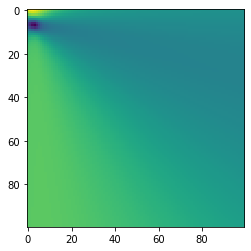

In [28]:
plt.imshow(mrs)

----